In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mssng
import statsmodels.api as sm

In [11]:
data = pd.read_csv("bestsellers with categories.csv")
df = data.copy()
df.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


<Axes: >

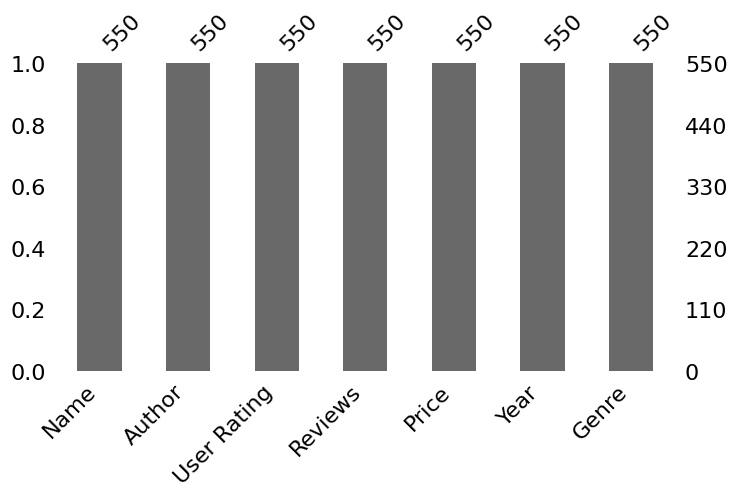

In [17]:
mssng.bar(df,figsize=(8,4))

<Axes: >

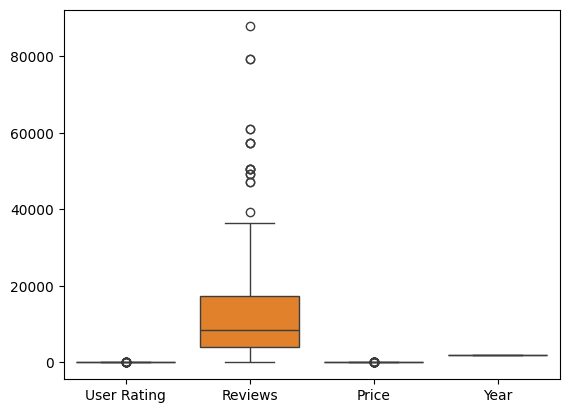

In [100]:
sns.boxplot(data=data)


--- Name --- (Atlandı: Sayısal değil!)

--- Author --- (Atlandı: Sayısal değil!)

--- User Rating ---


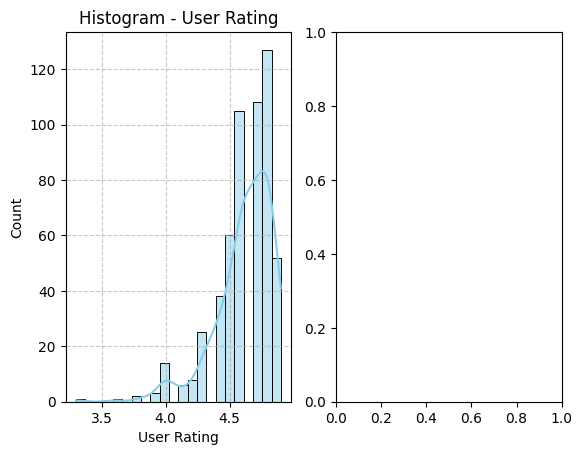

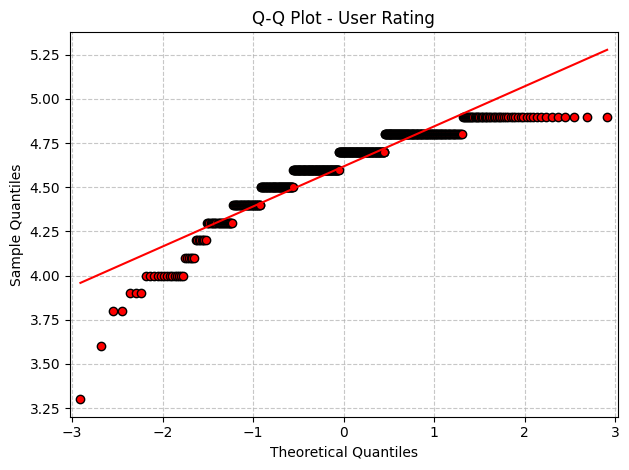


--- Reviews ---


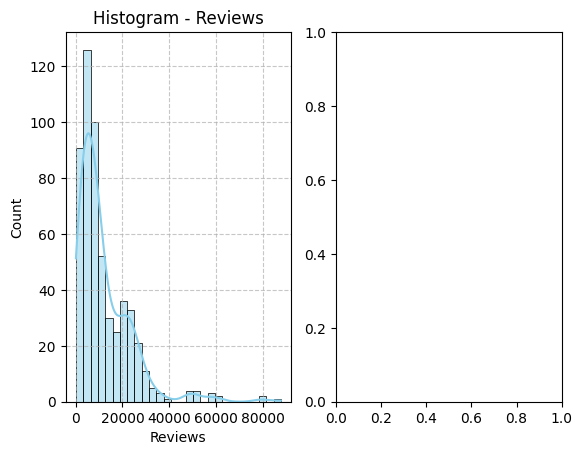

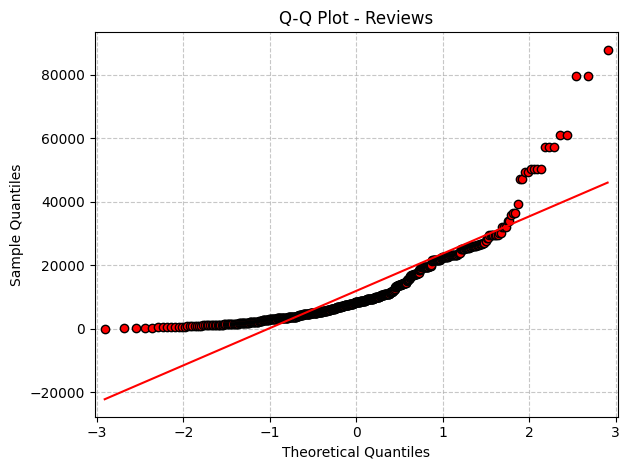


--- Price ---


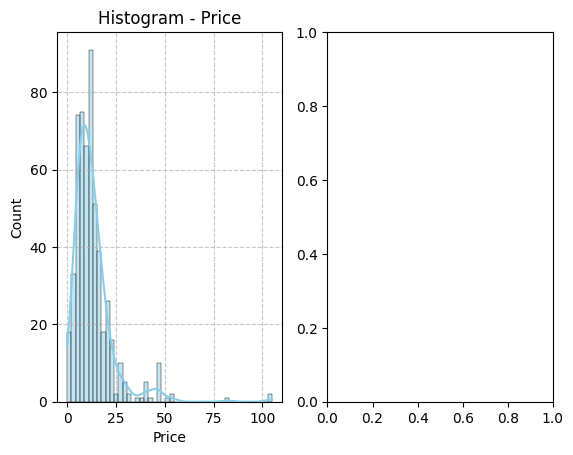

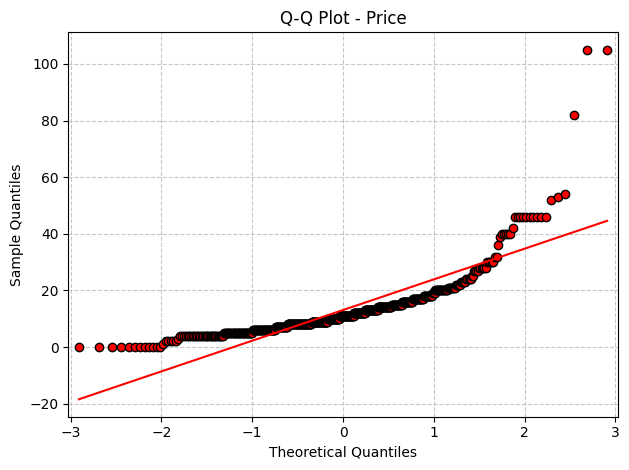


--- Year ---


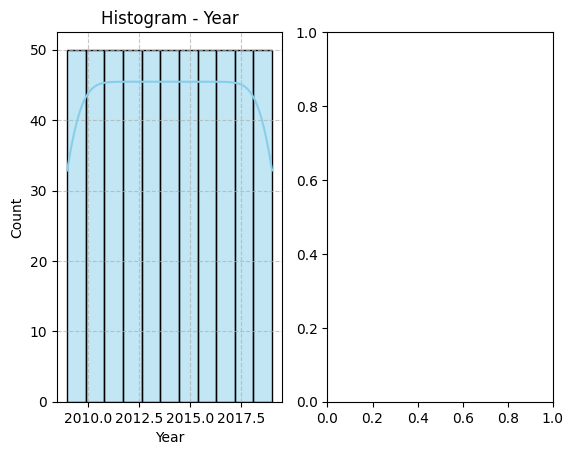

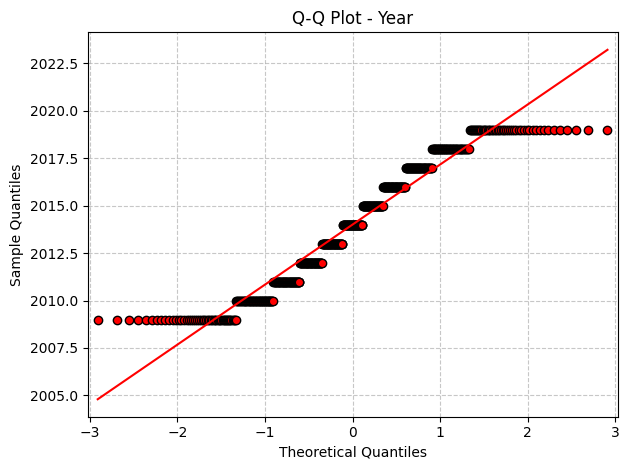


--- Genre --- (Atlandı: Sayısal değil!)


In [19]:
def check_normality(df):
    for column in df.columns:
        # SADECE SAYISAL SÜTUNLARI KONTROL ET
        if not pd.api.types.is_numeric_dtype(df[column]):
            print(f"\n--- {column} --- (Atlandı: Sayısal değil!)")
            continue
            
        print(f"\n--- {column} ---")
        
        try:                        
            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(df[column], kde=True, color='skyblue', edgecolor='black')
            plt.title(f'Histogram - {column}', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # Q-Q Plot
            plt.subplot(1, 2, 2)
            sm.qqplot(df[column].dropna(), line='s', markersize=6, 
                     markerfacecolor='red', markeredgecolor='black')
            plt.title(f'Q-Q Plot - {column}', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Hata: {str(e)}")

check_normality(df)

Normal dağılım olmadığı için Z-score yerine IQR kullanılacak

In [22]:
df["Genre"].unique()

array(['Non Fiction', 'Fiction'], dtype=object)

In [76]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,roc_curve, auc , f1_score , recall_score

In [30]:
df.dtypes

## Genre target, encode edilecek

Name            object
Author          object
User Rating    float64
Reviews          int64
Price            int64
Year             int64
Genre           object
dtype: object

In [33]:
df.drop(columns=["Name","Author"],inplace=True)

In [35]:
df.head()

,User Rating,Reviews,Price,Year,Genre
0,4.7,17350,8,2016,Non Fiction
1,4.6,2052,22,2011,Fiction
2,4.7,18979,15,2018,Non Fiction
3,4.7,21424,6,2017,Fiction
4,4.8,7665,12,2019,Non Fiction


In [90]:
y = df["Genre"]
X = df.drop(columns="Genre")

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=11)

In [91]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
y_train = ohe.fit_transform(y_train.values.reshape(-1,1))
y_test =  ohe.transform(y_test.values.reshape(-1,1))
y_train = y_train.ravel()
y_test = y_test.ravel()

In [92]:
x_train.columns

Index(['User Rating', 'Reviews', 'Price', 'Year'], dtype='object')

In [93]:
# outliers IQR
def outlier_impute(train,test):
    train_columns = train.columns
    test_columns = test.columns

    train_imputed = train.copy() 
    test_imputed = test.copy()   

    for col in train_columns:
        if train[col].dtype in ['int64', 'float64']: 
            Q1_train = train[col].quantile(0.25) 
            Q3_train = train[col].quantile(0.75) 
            IQR_train = Q3_train - Q1_train
            lower_bound_train = Q1_train - 1.5 * IQR_train
            upper_bound_train = Q3_train + 1.5 * IQR_train
    
            train_outliers_mask = (train[col] < lower_bound_train) | (train[col] > upper_bound_train)
            test_outliers_mask = (test[col] < lower_bound_train) | (test[col] > upper_bound_train)
            train_col_values = train[[col]]
            test_col_values = test[[col]]
            imputer_mean = SimpleImputer(strategy='mean')
    
            imputer_mean.fit(train_col_values)
    
            train_imputed_col = imputer_mean.transform(train_col_values)
            test_imputed_col = imputer_mean.transform(test_col_values)
    
            train_imputed[col] = train_imputed_col
            test_imputed[col] = test_imputed_col
    return train_imputed, test_imputed

In [94]:
x_train,x_test =  outlier_impute(x_train,x_test)

In [95]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [96]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=11),
        'SVM': SVC(probability=True, random_state=11),
        'Random Forest': RandomForestClassifier(random_state=11),
        'XGBoost': XGBClassifier(random_state=11)
    }
    results = {}
    for name, model in models.items():
        print(f"\n{'-'*60}")
        print(f"Training and evaluating {name}...")
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        print(f"\nModel: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Recall: {recall:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        if len(set(y_test)) == 2 and hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            print(f"ROC AUC: {roc_auc:.4f}")
            
            roc_data = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
        else:
            roc_data = None
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'roc_data': roc_data
        }
    
    return results



------------------------------------------------------------
Training and evaluating Logistic Regression...

Model: Logistic Regression
Accuracy: 0.5636
F1 Score: 0.5442
Recall: 0.5636

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.34      0.41        50
         1.0       0.58      0.75      0.65        60

    accuracy                           0.56       110
   macro avg       0.55      0.55      0.53       110
weighted avg       0.56      0.56      0.54       110

ROC AUC: 0.6617

------------------------------------------------------------
Training and evaluating SVM...

Model: SVM
Accuracy: 0.6818
F1 Score: 0.6786
Recall: 0.6818

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.58      0.62        50
         1.0       0.69      0.77      0.72        60

    accuracy                           0.68       110
   macro avg       0.68      0.67      0.67       1

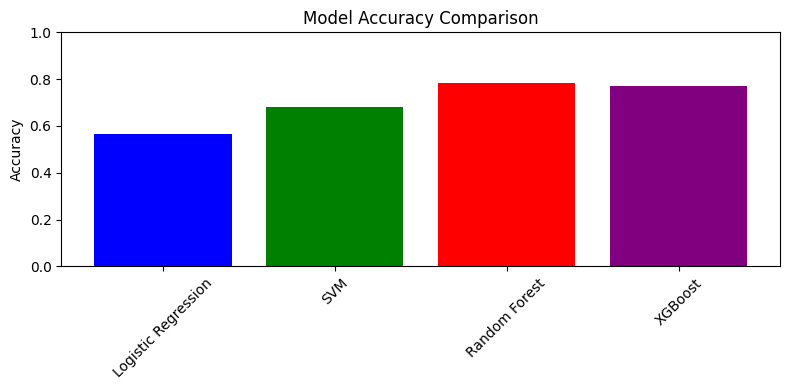

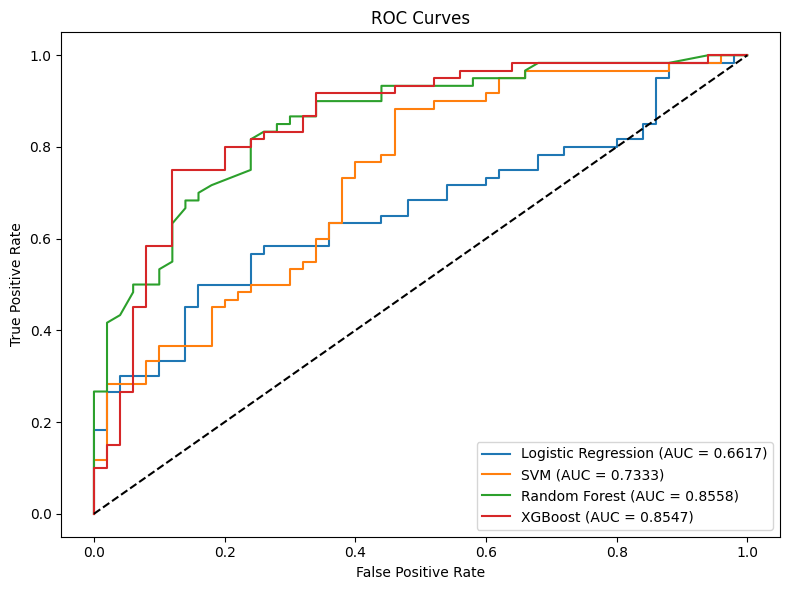

In [98]:
model_results = train_and_evaluate_models(x_train, x_test, y_train, y_test)

models = list(model_results.keys())
accuracies = [results['accuracy'] for results in model_results.values()]
f1_scores = [results['f1_score'] for results in model_results.values()]
recall_scores = [results['recall'] for results in model_results.values()]

plt.figure(figsize=(8, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for name, results in model_results.items():
    if results['roc_data']:
        plt.plot(
            results['roc_data']['fpr'], 
            results['roc_data']['tpr'], 
            label=f"{name} (AUC = {results['roc_data']['auc']:.4f})"
        )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()